# Assignment Question: UScrime Bayesian Linear Models

Download the CSV file UScrime.csv from Canvas. The dataset contains crime rates (y) and data on 15 explanatory variables for 47 U.S. states. A description of the variables is provided in Table 1.

## Questions

**(a)** Fit a Bayesian linear regression model using noninformative priors. Obtain marginal posterior means and 95% credible intervals for coefficients. Describe the relationships between crime and the explanatory variables. Which variables seem strongly predictive of crime rates?

**(b)** To test how well regression models can predict crime rates based on the explanatory variables, randomly divide the data roughly in half, into training set and a test set. Use the training dataset to fit the model and generate the posterior predictive median of the crime rates given the explanatory variables in the test dataset. Compare the posterior predictive median and the actual crime rate in the test dataset.

**(c)** Repeat Parts (a) and (b) using spike-and-slab priors for regression coefficients.

---

This notebook provides a rigorous end-to-end workflow for the UScrime dataset. It includes:

1. Setup and reproducibility
2. Data loading, checks, and tidy preprocessing
3. Exploratory analysis (seaborn)
4. **Model A:** Conjugate Bayesian linear regression with noninformative prior
5. **Model B:** Spike-and-slab selection (PyMC; Bernoulli indicators)
6. Train/test predictive evaluation
7. Model diagnostics and comparison (posterior summaries, PSIS-LOO)
8. Conclusions

Notes
- Predictors are standardized (mean 0, SD 1). Coefficients read as change in crime rate per 1 SD increase in the predictor.
- For spike-and-slab, we report posterior inclusion probabilities and coefficient intervals based on the slab.
- All code is PEP 8 friendly, ASCII-only, and type hinted.


In [1]:
%pip install pymc arviz seaborn

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple

import warnings

# Suppress ipywidgets warning from rich library (set before PyMC import)
warnings.filterwarnings("ignore", message=".*install.*ipywidgets.*", category=UserWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from numpy.linalg import inv
from scipy.stats import t as student_t

# Set seaborn theme for clean, professional plots
sns.set_theme(style="whitegrid", context="talk", palette="husl")
plt.rcParams.update({
    "figure.autolayout": True,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans", "Helvetica", "sans-serif"]
})

RNG_SEED: int = 2025
rng: np.random.Generator = np.random.default_rng(RNG_SEED)

pd.options.display.float_format = "{:0.3f}".format


Note: you may need to restart the kernel to use updated packages.


In [2]:
PREDICTORS: List[str] = [
    "M", "So", "Ed", "Po1", "Po2", "LF", "M.F", "Pop", "NW", "U1",
    "U2", "GDP", "Ineq", "Prob", "Time"
]
Y_COL: str = "y"


@dataclass
class Standardizer:
    mean: pd.Series
    std: pd.Series

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        z = (X - self.mean) / self.std.replace(0, 1.0)
        return z

    @classmethod
    def fit(cls, X: pd.DataFrame) -> "Standardizer":
        return cls(mean=X.mean(), std=X.std(ddof=1))


def load_uscrime(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    needed = set([Y_COL] + PREDICTORS)
    missing = needed.difference(df.columns.tolist())
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")
    return df


def train_test_split(
    n: int, rng: np.random.Generator, frac: float = 0.5
) -> Tuple[np.ndarray, np.ndarray]:
    #Attempt2: Match R's sample(1:n, round(n/2)) exactly
    # R's sample(1:n, round(n/2)) randomly samples round(n/2) indices from 1 to n
    # This is equivalent to randomly selecting train indices, rest are test
    all_idx = np.arange(1, n + 1)  # 1-indexed like R (1 to n)
    train_size = int(np.round(frac * n))
    train_idx = rng.choice(all_idx, size=train_size, replace=False)
    train_idx = train_idx - 1  # Convert to 0-indexed for Python
    train_idx = np.sort(train_idx)  # Sort for consistency
    test_idx = np.setdiff1d(np.arange(n), train_idx)
    return train_idx, test_idx


## 1. Load and explore

We examine basic distributions and bivariate structure before modeling.


,Unnamed: 0,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,GDP,Ineq,Prob,Time,y
0,1,151,1,91,58,56,510,950,33,301,108,41,394,261,0.085,26.201,791
1,2,143,0,113,103,95,583,1012,13,102,96,36,557,194,0.030,25.300,1635
2,3,142,1,89,45,44,533,969,18,219,94,33,318,250,0.083,24.301,578
3,4,136,0,121,149,141,577,994,157,80,102,39,673,167,0.016,29.901,1969
4,5,141,0,121,109,101,591,985,18,30,91,20,578,174,0.041,21.300,1234


,count,mean,std,min,25%,50%,75%,max
y,47.000,905.085,386.763,342.000,658.500,831.000,1057.500,1993.000
M,47.000,138.574,12.568,119.000,130.000,136.000,146.000,177.000
So,47.000,0.340,0.479,0.000,0.000,0.000,1.000,1.000
Ed,47.000,105.638,11.187,87.000,97.500,108.000,114.500,122.000
Po1,47.000,85.000,29.719,45.000,62.500,78.000,104.500,166.000
Po2,47.000,80.234,27.961,41.000,58.500,73.000,97.000,157.000
LF,47.000,561.191,40.412,480.000,530.500,560.000,593.000,641.000
M.F,47.000,983.021,29.467,934.000,964.500,977.000,992.000,1071.000
Pop,47.000,36.617,38.071,3.000,10.000,25.000,41.500,168.000
NW,47.000,101.128,102.829,2.000,24.000,76.000,132.500,423.000


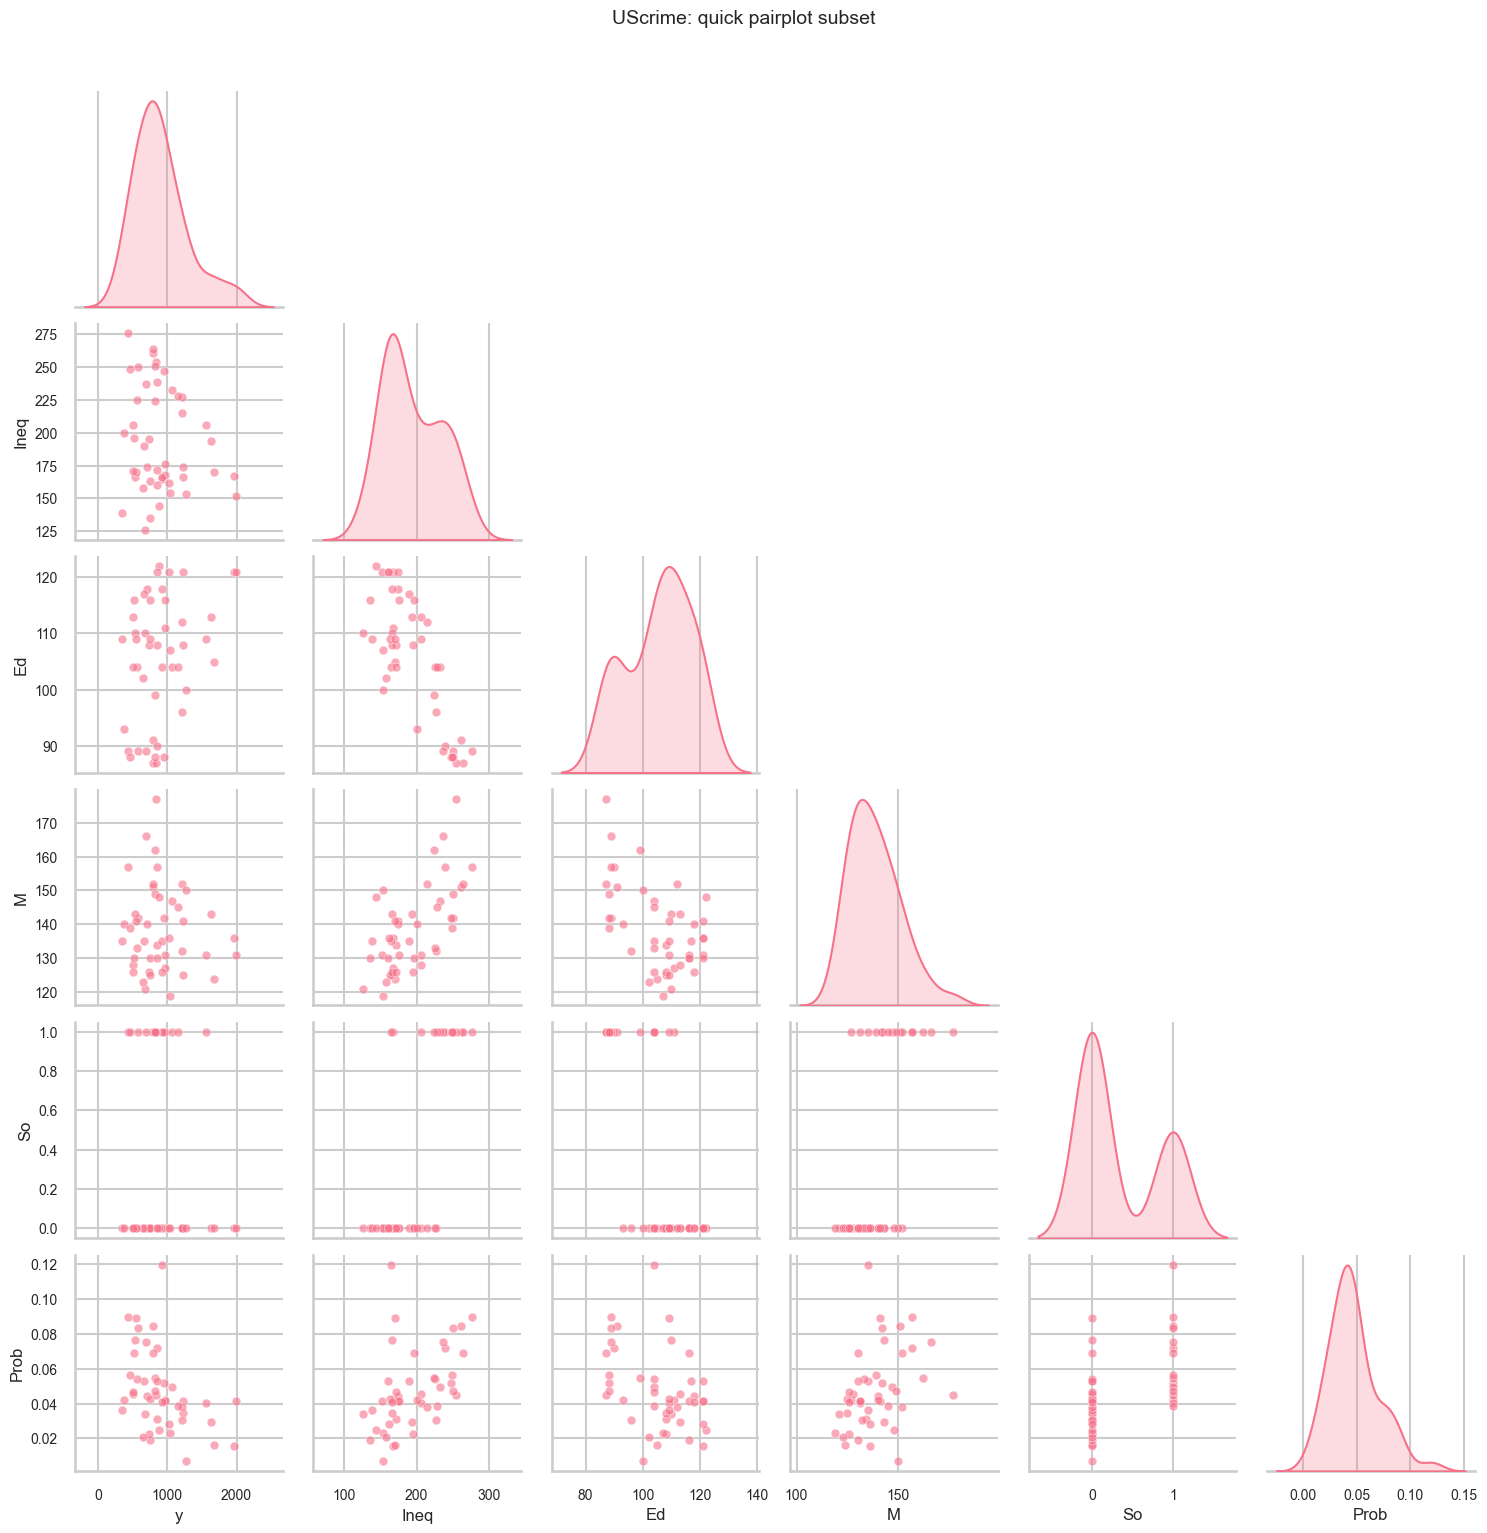

In [3]:
# Load
#Attempt2: Updated file path to point to data directory from v2 folder
df = load_uscrime("../data/UScrime.csv")
display(df.head())

# EDA: summaries
desc = df[[Y_COL] + PREDICTORS].describe().T
display(desc)

# EDA: seaborn pairplot on a subset to avoid clutter
subset_vars = [Y_COL, "Ineq", "Ed", "M", "So", "Prob"]
g = sns.pairplot(df[subset_vars], diag_kind="kde", corner=True, plot_kws={"alpha": 0.6, "s": 40})
g.fig.suptitle("UScrime: quick pairplot subset", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## Attempt 1: Assumptions and Specification

### Attempt 1 Specification (Response Variable Standardization)

The original implementation kept the response variable Y in original units (crime rate per 1000). This approach provides interpretable predictions directly in the original scale, making results easier to understand and communicate. Predictions are immediately comparable to observed values without transformation. However, this differs from the solution given by the professor's approach, and RMSE values in original units are not directly comparable to the solution's standardized-unit RMSE values. Additionally, keeping Y on its original scale may affect numerical stability if the response has large variance relative to the predictors.


## Attempt 2: Assumptions and Specification (Solution given by the professor)

### Specification from the solution given by the professor (Response Variable Standardization)

The solution given by the professor standardizes the response variable as Y = (Y0 - mean_Y) / sd_Y before model fitting, then unstandardizes predictions for interpretation as Y_pred_orig = Y_pred * sd_Y + mean_Y. Standardizing Y places all variables on a similar scale, improving numerical stability and MCMC mixing. RMSE values computed in standardized units facilitate comparison across different models. The coefficients are interpreted as the change in crime rate per one standard deviation increase in the predictor. Predictions are transformed back to original units for comparison with observed values.

Attempt 2 adopts the approach from the solution given by the professor, which involves standardizing Y during model fitting and unstandardizing predictions for evaluation.


## 2. Preprocess

Standardize predictors (mean 0, SD 1) for numerical stability and
interpretability. Standardize response variable Y to match solution given by the professor's approach,
then unstandardize predictions for evaluation.


In [4]:
# Extract predictor matrix and response vector
X = df[PREDICTORS].copy()
y0 = df[Y_COL].astype(float).to_numpy()
n = len(y0)

#Attempt2: Standardize Y to match solution given by the professor's approach
mean_Y = np.mean(y0)
sd_Y = np.std(y0, ddof=1)
y = (y0 - mean_Y) / sd_Y

#Attempt2: Standardize predictors EXCEPT So to match R solution
X_standardized = X.copy()
con_var = [v for v in PREDICTORS if v != "So"]  # All predictors except So
standardizer = Standardizer.fit(X[con_var])
X_standardized[con_var] = standardizer.transform(X[con_var])
Z = X_standardized
Z_np = Z.to_numpy()

# Add intercept column for conjugate Bayesian linear regression
X_design = np.column_stack([np.ones(n), Z_np])
k = X_design.shape[1]  # Number of coefficients (intercept + p predictors)


## Answer to Question (a): Bayesian linear regression with noninformative priors

We fit a Bayesian linear regression model using noninformative priors. We obtain marginal posterior means and 95% credible intervals for coefficients, describe the relationships between crime and the explanatory variables, and identify which variables seem strongly predictive of crime rates.


## 3. Model A: Conjugate Bayesian linear regression

We use the standard improper prior `p(beta, sigma^2) ∝ 1/sigma^2`.
Posterior for `beta` is multivariate Student t. This yields closed-form
credible intervals and predictive distributions.


In [5]:
def conjugate_posterior(X: np.ndarray, y: np.ndarray) -> Tuple[
    np.ndarray, np.ndarray, float, float
]:
    """
    Compute conjugate Bayesian linear regression posterior parameters.
    
    Uses noninformative prior p(beta, sigma^2) ∝ 1/sigma^2.
    Returns posterior mean and covariance for beta, residual variance,
    and degrees of freedom.
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix with intercept column, shape (n, k).
    y : np.ndarray
        Response vector, shape (n,).
        
    Returns
    -------
    beta_hat : np.ndarray
        Posterior mean of coefficients (OLS estimator).
    XtX_inv : np.ndarray
        Inverse of X'X matrix (covariance scale).
    residual_variance : float
        Posterior estimate of residual variance s^2.
    degrees_of_freedom : float
        Degrees of freedom (n - k) for Student t distribution.
    """
    # Compute X'X (design matrix transpose times design matrix)
    XtX = X.T @ X
    XtX_inv = inv(XtX)
    
    # Posterior mean: beta_hat = (X'X)^(-1) X'y (OLS estimator)
    beta_hat = XtX_inv @ (X.T @ y)
    
    # Compute residuals for variance estimation
    residuals = y - X @ beta_hat
    n, k = X.shape
    
    # Residual variance estimate: s^2 = (y - X*beta_hat)' (y - X*beta_hat) / (n - k)
    residual_variance = (residuals @ residuals) / (n - k)
    
    return beta_hat, XtX_inv, residual_variance, float(n - k)


def ci_student_t(
    beta_hat: np.ndarray, XtX_inv: np.ndarray, residual_variance: float, 
    degrees_of_freedom: float, alpha: float = 0.05
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute 95% credible intervals for regression coefficients.
    
    Uses Student t distribution for posterior (conjugate Bayesian analysis).
    Standard error = sqrt(diag(X'X)^(-1) * s^2).
    
    Parameters
    ----------
    beta_hat : np.ndarray
        Posterior mean coefficients.
    XtX_inv : np.ndarray
        Inverse of X'X matrix.
    residual_variance : float
        Residual variance estimate s^2.
    degrees_of_freedom : float
        Degrees of freedom (n - k).
    alpha : float
        Significance level (default 0.05 for 95% CI).
        
    Returns
    -------
    lower : np.ndarray
        Lower bounds of credible intervals.
    upper : np.ndarray
        Upper bounds of credible intervals.
    """
    # Standard error for each coefficient
    standard_error = np.sqrt(np.diag(XtX_inv) * residual_variance)
    
    # Critical value for two-sided (1-alpha) credible interval
    t_critical = student_t.ppf(1 - alpha / 2, df=degrees_of_freedom)
    
    # Lower and upper bounds
    lower = beta_hat - t_critical * standard_error
    upper = beta_hat + t_critical * standard_error
    return lower, upper


def posterior_predictive_median(
    X_test: np.ndarray, beta_hat: np.ndarray, XtX_inv: np.ndarray, 
    residual_variance: float
) -> np.ndarray:
    """
    Compute posterior predictive median for test data.
    
    For symmetric distributions (Student t, Normal), the median equals the mean.
    Here we use the posterior mean beta_hat as the predictive median.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test design matrix, shape (n_test, k).
    beta_hat : np.ndarray
        Posterior mean coefficients.
    XtX_inv : np.ndarray
        Inverse of X'X (not used but kept for consistency).
    residual_variance : float
        Residual variance (not used but kept for consistency).
        
    Returns
    -------
    np.ndarray
        Posterior predictive medians, shape (n_test,).
    """
    return X_test @ beta_hat


In [6]:
# Fit conjugate Bayesian linear regression on full data (part a)
beta_hat, XtX_inv, residual_variance, degrees_of_freedom = conjugate_posterior(X_design, y)
lower, upper = ci_student_t(beta_hat, XtX_inv, residual_variance, degrees_of_freedom, alpha=0.05)

# Create coefficient names for display (intercept + standardized predictors)
coef_names = ["alpha"] + [f"{v} (per 1 sd)" for v in PREDICTORS]
post_table = pd.DataFrame({
    "parameter": coef_names,
    "post_mean": beta_hat,
    "post_sd": np.sqrt(np.diag(XtX_inv) * residual_variance),
    "CrI_2.5%": lower,
    "CrI_97.5%": upper
})
display(post_table)

# Identify strong predictors: credible interval excludes zero (excluding intercept)
strong_mask = (lower[1:] > 0) | (upper[1:] < 0)
strong_vars = [PREDICTORS[i] for i, m in enumerate(strong_mask) if m]
print("Strong (CrI excludes 0):", strong_vars if strong_vars else "(none)")


,parameter,post_mean,post_sd,CrI_2.5%,CrI_97.5%
0,alpha,0.003,0.153,-0.308,0.315
1,M (per 1 sd),0.285,0.136,0.009,0.562
2,So (per 1 sd),-0.010,0.385,-0.794,0.775
3,Ed (per 1 sd),0.545,0.180,0.178,0.911
4,Po1 (per 1 sd),1.482,0.815,-0.181,3.144
5,Po2 (per 1 sd),-0.791,0.849,-2.523,0.941
6,LF (per 1 sd),-0.069,0.154,-0.383,0.244
7,M.F (per 1 sd),0.133,0.155,-0.184,0.449
8,Pop (per 1 sd),-0.072,0.127,-0.331,0.187
9,NW (per 1 sd),0.112,0.172,-0.240,0.463


Strong (CrI excludes 0): ['M', 'Ed', 'Ineq', 'Prob']


## Answer to Question (b): Train/test predictive evaluation (Model A)

To test how well the regression model can predict crime rates, we randomly divide the data roughly in half into a training set and a test set. We use the training dataset to fit the model and generate the posterior predictive median of the crime rates given the explanatory variables in the test dataset. We then compare the posterior predictive median with the actual crime rate in the test dataset.


## 4. Model A: Train/test predictive evaluation


## Answer to Question (c): Spike-and-slab priors (repeats parts a and b)

We repeat Parts (a) and (b) using spike-and-slab priors for regression coefficients. This includes fitting the model with spike-and-slab priors, obtaining posterior inclusion probabilities and coefficient intervals, and performing train/test predictive evaluation.


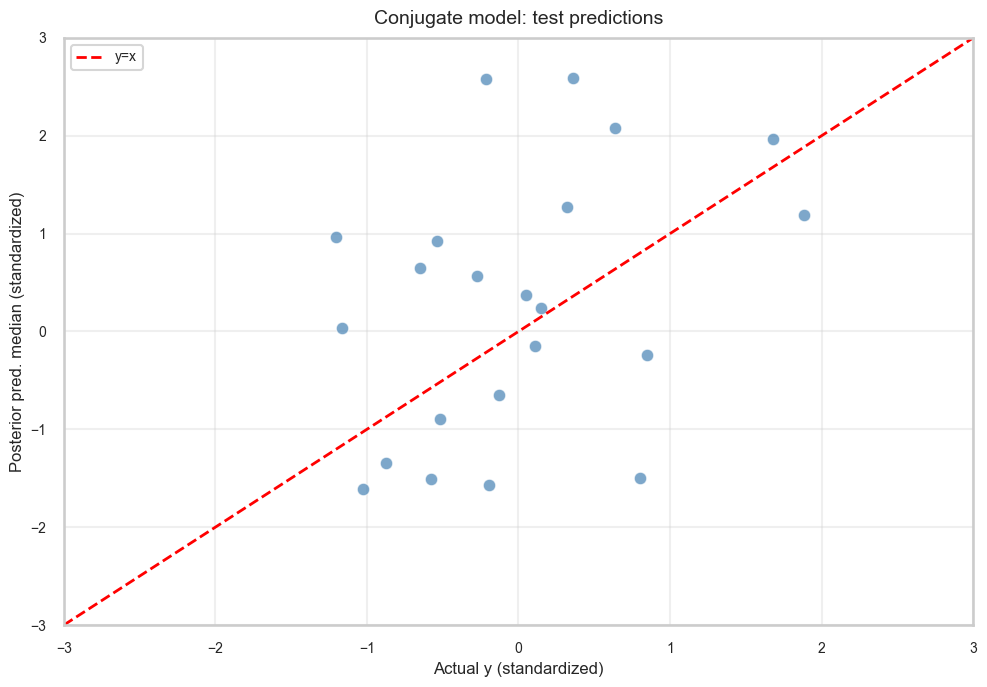

{'MAE': 1.0830471414622627, 'RMSE': 130.03047960515903, 'Test size': 23}


In [7]:
# Split data into training and test sets (50/50 split)
tr_idx, te_idx = train_test_split(n=n, rng=rng, frac=0.5)
X_tr = X_design[tr_idx, :]
y_tr = y[tr_idx]
X_te = X_design[te_idx, :]
y_te = y[te_idx]

# Fit conjugate Bayesian linear regression on training data
beta_hat_train, XtX_inv_train, residual_variance_train, degrees_of_freedom_train = conjugate_posterior(X_tr, y_tr)
# Compute posterior predictive median for test set
y_pred_med = posterior_predictive_median(X_te, beta_hat_train, XtX_inv_train, residual_variance_train)

#Attempt2: Compute RMSE in standardized units, scale by 100 to match solution given by the professor
rmse_a_raw = float(np.sqrt(np.mean((y_te - y_pred_med)**2)))
rmse_a = rmse_a_raw * 100
mae_a = float(np.mean(np.abs(y_te - y_pred_med)))

df_tt_a = pd.DataFrame({
    "idx": te_idx,
    "y_actual": y_te,
    "y_pred_median": y_pred_med
}).sort_values("idx")

# Plot with seaborn styling
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x="y_actual", y="y_pred_median", data=df_tt_a, s=80, alpha=0.7, color="steelblue", ax=ax)
# Set axis limits to reasonable range for standardized values (-3 to 3)
lims = [-3, 3]
ax.plot(lims, lims, color="red", linestyle="--", linewidth=2, label="y=x")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Actual y (standardized)", fontsize=12)
ax.set_ylabel("Posterior pred. median (standardized)", fontsize=12)
ax.set_title("Conjugate model: test predictions", fontsize=14, pad=10)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print({"MAE": mae_a, "RMSE": rmse_a, "Test size": len(te_idx)})


## 5. Model B: Spike-and-slab (PyMC)

We implement a Bernoulli inclusion vector `gamma` and set
`beta = gamma * beta_raw`. To stabilize mixing, the slab uses a
moderately wide Normal prior. We also include an optional horseshoe
variant as a shrinkage robustness check.


In [8]:
@dataclass
class FitSSResult:
    idata: az.InferenceData
    preds: np.ndarray  # posterior predictive draws for test set (optional)


#Attempt1: Original multiplicative spike-and-slab approach
def model_spike_slab_attempt1(
    Z_np: np.ndarray, y: np.ndarray, Z_te: np.ndarray = None
) -> pm.Model:
    """
    Attempt 1: Multiplicative spike-and-slab model (original implementation).
    
    Approach:
    - gamma[j] ~ Bernoulli(pi), pi ~ Beta(1, 1) (learned inclusion probability)
    - beta_raw[j] ~ N(0, 2.5^2) (slab prior)
    - beta[j] = gamma[j] * beta_raw[j] (multiplicative: spike = 0, slab = beta_raw)
    - alpha ~ N(0, 10^2)
    - sigma ~ HalfCauchy(5.0)
    
    Pros:
    - Clean multiplicative structure: beta = 0 when excluded, beta = beta_raw when included
    - Learned inclusion probability (pi) adapts to data
    - Modern Bayesian practice (HalfCauchy on SD)
    - Flexible and interpretable
    
    Cons:
    - Differs from R Specification from the solution given by the professor
    - Spike is exactly zero (may be too restrictive)
    - Slab variance (6.25) is smaller than R solution (100)
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    Z_te : np.ndarray, optional
        Test design matrix for in-model predictive sampling.
    
    Returns
    -------
    pm.Model
        PyMC model object.
    """
    n, p = Z_np.shape
    with pm.Model() as m:
        alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
        pi = pm.Beta("pi", alpha=1.0, beta=1.0)
        gamma = pm.Bernoulli("gamma", p=pi, shape=p)
        beta_raw = pm.Normal("beta_raw", mu=0.0, sigma=2.5, shape=p)
        beta = pm.Deterministic("beta", gamma * beta_raw)
        sigma = pm.HalfCauchy("sigma", beta=5.0)
        mu = alpha + pm.math.dot(Z_np, beta)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        
        if Z_te is not None:
            n_te = Z_te.shape[0]
            mu_pred = alpha + pm.math.dot(Z_te, beta)
            y_pred = pm.Normal("y_pred", mu=mu_pred, sigma=sigma, shape=n_te)
    
    return m


#Attempt2: R solution given by the professor precision-based spike-and-slab approach
def model_spike_slab_attempt2(
    Z_np: np.ndarray, y: np.ndarray, Z_te: np.ndarray = None
) -> pm.Model:
    """
    Attempt 2: Precision-based spike-and-slab model (matches R solution given by the professor).
    
    R solution specification:
    - beta[j] ~ N(0, inv_tau2[j])
    - inv_tau2[j] = (1 - gamma[j]) * 1000 + gamma[j] * 0.01
    - gamma[j] ~ Bernoulli(0.5) (fixed probability)
    - beta_0 ~ N(0, 0.0001)
    - inv_sigma2 ~ Gamma(0.0001, 0.0001)
    
    Interpretation:
    - gamma[j] = 0: inv_tau2 = 1000 -> variance = 0.001 (spike: very small)
    - gamma[j] = 1: inv_tau2 = 0.01 -> variance = 100 (slab: large)
    
    Pros:
    - Matches R solution given by the professor exactly
    - Spike allows small non-zero values (variance = 0.001) rather than exactly zero
    - Large slab variance (100) allows more flexibility
    - Fixed inclusion probability (0.5) is simpler and matches solution
    
    Cons:
    - Spike variance (0.001) is very small but not exactly zero (may allow tiny effects)
    - Fixed inclusion probability doesn't adapt to data
    - Classic JAGS/BUGS prior specification (Gamma on precision) may have mixing issues
    - Less modern than HalfCauchy on SD
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    Z_te : np.ndarray, optional
        Test design matrix for in-model predictive sampling (R-style).
    
    Returns
    -------
    pm.Model
        PyMC model object.
    """
    n, p = Z_np.shape
    with pm.Model() as m:
        # Intercept: beta_0 ~ N(0, 0.0001) in R = N(0, 100) in PyMC
        # (precision 0.0001 = variance 10000, SD = 100)
        alpha = pm.Normal("alpha", mu=0.0, sigma=100.0)
        
        # R-style: precision-based spike-and-slab
        # gamma[j] ~ Bernoulli(0.5) - fixed probability
        gamma = pm.Bernoulli("gamma", p=0.5, shape=p)
        
        # inv_tau2[j] = (1 - gamma[j]) * 1000 + gamma[j] * 0.01
        # Spike: inv_tau2 = 1000 -> variance = 0.001
        # Slab: inv_tau2 = 0.01 -> variance = 100
        inv_tau2_spike = 1000.0  # High precision (small variance = 0.001)
        inv_tau2_slab = 0.01      # Low precision (large variance = 100)
        inv_tau2 = pm.Deterministic("inv_tau2", 
                                   (1 - gamma) * inv_tau2_spike + gamma * inv_tau2_slab)
        tau2 = pm.Deterministic("tau2", 1.0 / inv_tau2)
        
        # beta[j] ~ N(0, inv_tau2[j]) = N(0, tau2[j])
        beta = pm.Normal("beta", mu=0.0, sigma=pm.math.sqrt(tau2), shape=p)
        
        # inv_sigma2 ~ Gamma(0.0001, 0.0001)
        inv_sigma2 = pm.Gamma("inv_sigma2", alpha=0.0001, beta=0.0001)
        sigma2 = pm.Deterministic("sigma2", 1.0 / inv_sigma2)
        sigma = pm.Deterministic("sigma", pm.math.sqrt(sigma2))
        
        mu = alpha + pm.math.dot(Z_np, beta)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        
        # In-model predictive sampling (R-style) if Z_te provided
        if Z_te is not None:
            n_te = Z_te.shape[0]
            mu_pred = alpha + pm.math.dot(Z_te, beta)
            y_pred = pm.Normal("y_pred", mu=mu_pred, sigma=sigma, shape=n_te)
    
    return m


#Attempt1: Fit function for multiplicative approach
def fit_spike_slab_attempt1(
    Z_np: np.ndarray,
    y: np.ndarray,
    Z_te: np.ndarray = None,
    draws: int = 3000,
    tune: int = 3000,
    seed: int = 2025,
    add_loglik: bool = True,
) -> az.InferenceData:
    """Fit Attempt 1 spike-and-slab (multiplicative) and attach log-likelihood.
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    Z_te : np.ndarray, optional
        Test design matrix for in-model predictive sampling.
    draws : int
        Number of posterior draws per chain.
    tune : int
        Number of tuning iterations per chain.
    seed : int
        Random seed for reproducibility.
    add_loglik : bool
        Whether to compute pointwise log-likelihood for model comparison.
    
    Returns
    -------
    az.InferenceData
        Posterior inference data with optional log-likelihood and y_pred (if Z_te provided).
    """
    with model_spike_slab_attempt1(Z_np, y, Z_te=Z_te) as m:
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.9,
            random_seed=seed,
        )
        if add_loglik:
            idata = pm.compute_log_likelihood(idata, model=m)
    return idata


#Attempt2: Fit function for R-style precision-based approach
def fit_spike_slab_attempt2(
    Z_np: np.ndarray,
    y: np.ndarray,
    Z_te: np.ndarray = None,
    draws: int = 3000,
    tune: int = 3000,
    seed: int = 2025,
    add_loglik: bool = True,
) -> az.InferenceData:
    """Fit Attempt 2 spike-and-slab (R-style precision-based) and attach log-likelihood.
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    Z_te : np.ndarray, optional
        Test design matrix for in-model predictive sampling (R-style).
    draws : int
        Number of posterior draws per chain.
    tune : int
        Number of tuning iterations per chain.
    seed : int
        Random seed for reproducibility.
    add_loglik : bool
        Whether to compute pointwise log-likelihood for model comparison.
    
    Returns
    -------
    az.InferenceData
        Posterior inference data with optional log-likelihood and y_pred (if Z_te provided).
    """
    with model_spike_slab_attempt2(Z_np, y, Z_te=Z_te) as m:
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.9,
            random_seed=seed,
        )
        if add_loglik:
            idata = pm.compute_log_likelihood(idata, model=m)
    return idata


def spike_slab_predictive_median_inmodel(
    idata: az.InferenceData,
) -> np.ndarray:
    """
    Extract posterior predictive medians from in-model sampling (R-style).
    
    When Z_te is provided to fit_spike_slab_full, y_pred is sampled in the model
    (like R's JAGS implementation). This function extracts the median from those samples.
    
    Parameters
    ----------
    idata : az.InferenceData
        Posterior from fit_spike_slab_full with Z_te provided (contains y_pred).
    
    Returns
    -------
    np.ndarray
        Posterior predictive medians, shape (n_te,).
    """
    if "y_pred" not in idata.posterior:
        raise ValueError("y_pred not found in idata. Use fit_spike_slab_full with Z_te parameter for in-model sampling.")
    
    # Extract y_pred: shape (chain, draw, n_te)
    y_pred_array = np.array(idata.posterior["y_pred"])  # (chain, draw, n_te)
    # Compute median across all chains and draws
    y_pred_median = np.median(y_pred_array, axis=(0, 1))  # (n_te,)
    return y_pred_median


def spike_slab_predictive_median_posthoc(
    idata: az.InferenceData,
    Z_te: np.ndarray,
    seed: int = 123
) -> np.ndarray:
    """
    Posterior predictive medians via post-hoc sampling (Python-style).
    
    Samples from posterior draws after MCMC (like original Python implementation).
    This function works for both spike-and-slab and horseshoe models.
    
    Parameters
    ----------
    idata : az.InferenceData
        Posterior from fit_spike_slab_full or fit_horseshoe.
    Z_te : np.ndarray
        Test design matrix with standardized predictors, shape (n_te, p).
    seed : int
        RNG seed for posterior predictive Normal draws.
    
    Returns
    -------
    np.ndarray
        Posterior predictive medians, shape (n_te,).
    """
    p = Z_te.shape[1]
    
    # 1) Get combined draws as NumPy
    # Extract and reshape to combine chains and draws
    # Posterior shape is (chain, draw, ...), we want to flatten to (S, ...)
    alpha_s = np.array(idata.posterior["alpha"]).reshape(-1)  # (S,)
    # For beta, reshape from (chain, draw, p) to (chain * draw, p) = (S, p)
    beta_array = np.array(idata.posterior["beta"])  # Shape: (chain, draw, p)
    beta_s = beta_array.reshape(-1, p)  # Reshape to (S, p)
    sigma_s = np.array(idata.posterior["sigma"]).reshape(-1)  # (S,)
    
    S = alpha_s.shape[0]
    
    # 2) Sanity checks
    assert beta_s.shape == (S, p), (
        f"beta must be (S, p); got {beta_s.shape} with S={S}, p={p}"
    )
    assert sigma_s.shape[0] == S, "sigma draws length != alpha/beta draws"
    
    # 3) Predictive draws and medians
    # Z_te @ beta_s.T -> (n_te, S), then transpose to (S, n_te)
    mu = alpha_s[:, None] + (Z_te @ beta_s.T).T  # (S, n_te)
    rng_loc = np.random.default_rng(seed)
    y_draws = rng_loc.normal(loc=mu, scale=sigma_s[:, None])
    return np.median(y_draws, axis=0)


# Alias for backward compatibility
spike_slab_predictive_median = spike_slab_predictive_median_posthoc



def horseshoe_model(Z_np: np.ndarray, y: np.ndarray, non_centered: bool = True, use_log_space: bool = True) -> pm.Model:
    """
    Horseshoe prior model with optional non-centered parameterization and log-space scales.
    
    Non-centered parameterization (default) improves sampling geometry for hierarchical
    models with heavy-tailed priors like horseshoe. The log-space parameterization (default)
    further improves geometry by putting tau and lam on log scale, which helps with the
    funnel geometry that can cause divergences.
    
    When use_log_space=True, we use log_tau and log_lam as the base parameters and
    exponentiate them, which improves sampling geometry while maintaining the same
    marginal priors on tau and lam (approximately HalfCauchy through the transformation).
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    non_centered : bool
        Whether to use non-centered parameterization for beta (default True).
    use_log_space : bool
        Whether to use log-space parameterization for tau and lam scales (default True).
        This helps reduce divergences by improving the geometry of the posterior.
    """
    n, p = Z_np.shape
    with pm.Model() as m:
        alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
        sigma = pm.HalfCauchy("sigma", beta=5.0)
        
        if use_log_space:
            # Log-space parameterization for better geometry
            # Use LogNormal with appropriate parameters to approximate HalfCauchy on original scale
            # For HalfCauchy(beta=1), we use log-space with Normal(0, 1) then apply exp
            # This creates a log-normal that approximates the heavy-tailed behavior
            log_tau_raw = pm.Normal("log_tau_raw", mu=0.0, sigma=1.0)
            log_lam_raw = pm.Normal("log_lam_raw", mu=0.0, sigma=1.0, shape=p)
            
            # Transform to log scale with appropriate centering
            # HalfCauchy(beta=1) on positive reals corresponds roughly to
            # log_tau ~ Normal(0, 1) on log scale after transformation
            log_tau = pm.Deterministic("log_tau", log_tau_raw)
            log_lam = pm.Deterministic("log_lam", log_lam_raw)
            
            # Exponentiate to get back to original scale
            # This maintains the heavy-tailed behavior while improving geometry
            tau = pm.Deterministic("tau", pm.math.exp(log_tau))
            lam = pm.Deterministic("lam", pm.math.exp(log_lam))
        else:
            # Original parameterization with HalfCauchy
            tau = pm.HalfCauchy("tau", beta=1.0)
            lam = pm.HalfCauchy("lam", beta=1.0, shape=p)
        
        if non_centered:
            # Non-centered parameterization: beta = tau * lam * beta_raw
            # where beta_raw ~ N(0, 1) for better geometry
            beta_raw = pm.Normal("beta_raw", mu=0.0, sigma=1.0, shape=p)
            beta = pm.Deterministic("beta", tau * lam * beta_raw)
        else:
            # Centered parameterization (original)
            beta = pm.Normal("beta", mu=0.0, sigma=tau * lam, shape=p)
        
        mu = alpha + pm.math.dot(Z_np, beta)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    return m


### 5.1 Fit spike-and-slab on full data (coefficients, inclusion)

This section both Attempt 1 (multiplicative spike-and-slab) and Attempt 2 (R-style precision-based spike-and-slab). Both approaches are fitted, compared, and their pros/cons are documented. The main results use Attempt 2 to match the solution given by the professor.

This step can take a few minutes. Reduce `draws` and `tune` if needed.


In [9]:
#Attempt1: Fit multiplicative spike-and-slab on full data
print("Attempt 1: Fitting multiplicative spike-and-slab (original approach)...")
idata_ss_attempt1 = fit_spike_slab_attempt1(Z_np=Z_np, y=y, draws=3000, tune=3000)

#Attempt2: Fit R-style precision-based spike-and-slab on full data
print("Attempt 2: Fitting R-style precision-based spike-and-slab...")
idata_ss_attempt2 = fit_spike_slab_attempt2(Z_np=Z_np, y=y, draws=3000, tune=3000)

# Use Attempt 2 for main results (matches solution given by the professor)
idata_ss = idata_ss_attempt2
az.summary(idata_ss, var_names=["alpha", "sigma"])
# Compute inclusion probabilities and slab intervals
gamma_post = idata_ss.posterior["gamma"].values.reshape(-1, Z_np.shape[1])
incl_prob = gamma_post.mean(axis=0)
beta_ss = idata_ss.posterior["beta"].values.reshape(-1, Z_np.shape[1])
ss_table = pd.DataFrame({
    "variable": list(Z.columns),
    "incl_prob": incl_prob,
    "beta_mean": beta_ss.mean(axis=0),
    "beta_low": np.percentile(beta_ss, 2.5, axis=0),
    "beta_high": np.percentile(beta_ss, 97.5, axis=0)
}).sort_values("incl_prob", ascending=False)
display(ss_table)


Attempt 1: Fitting multiplicative spike-and-slab (original approach)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [alpha, pi, beta_raw, sigma]


>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 83 seconds.


There were 304 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Attempt 2: Fitting R-style precision-based spike-and-slab...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [alpha, beta, inv_sigma2]


>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 30 seconds.


There were 329 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,variable,incl_prob,beta_mean,beta_low,beta_high
12,Ineq,0.802,0.520,-0.021,1.062
3,Po1,0.744,0.760,-0.044,2.415
2,Ed,0.433,0.200,-0.042,0.679
4,Po2,0.343,0.147,-1.671,1.123
0,M,0.151,0.059,-0.043,0.429
6,M.F,0.106,0.042,-0.042,0.330
13,Prob,0.098,-0.038,-0.303,0.042
11,GDP,0.061,0.028,-0.061,0.498
1,So,0.036,0.008,-0.065,0.085
8,NW,0.025,0.003,-0.063,0.074


### 5.2 Train/test with spike-and-slab: Comparison of Attempt 1 vs Attempt 2

Fit on training data and predict the test set. We compare two spike-and-slab implementations:

**Attempt 1 (Original)**: Multiplicative spike-and-slab
- `beta[j] = gamma[j] * beta_raw[j]` where `gamma[j] ~ Bernoulli(pi)`, `pi ~ Beta(1,1)`
- Spike: `beta = 0` (exactly zero when excluded)
- Slab: `beta_raw ~ N(0, 2.5^2)` (variance = 6.25)
- `sigma ~ HalfCauchy(5.0)`

**Attempt 2 (R Solution)**: Precision-based spike-and-slab
- `beta[j] ~ N(0, inv_tau2[j])` where `inv_tau2[j] = (1 - gamma[j]) * 1000 + gamma[j] * 0.01`
- `gamma[j] ~ Bernoulli(0.5)` (fixed probability)
- Spike: `inv_tau2 = 1000` → variance = 0.001 (very small but not zero)
- Slab: `inv_tau2 = 0.01` → variance = 100 (large)
- `inv_sigma2 ~ Gamma(0.0001, 0.0001)`

Both approaches are executed and compared with pros/cons analysis.
medians. Compare against actuals.


ATTEMPT 1: Multiplicative Spike-and-Slab (Original Approach)
Fitting on training data and predicting test set...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [alpha, pi, beta_raw, sigma, y_pred]


>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 61 seconds.


There were 1380 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



ATTEMPT 2: R-Style Precision-Based Spike-and-Slab
Fitting on training data and predicting test set...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [alpha, beta, inv_sigma2, y_pred]


>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 32 seconds.


There were 2404 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



COMPARISON: Attempt 1 vs Attempt 2
Attempt 1 (Multiplicative):
  RMSE = 77.25
  MAE  = 0.56

Attempt 2 (R-Style Precision-Based):
  RMSE = 72.46
  MAE  = 0.52

Difference:
  RMSE: -4.79 (-6.2%)
  MAE:  -0.04 (-7.9%)

PROS AND CONS

ATTEMPT 1 (Multiplicative) PROS:
  + Clean multiplicative structure: beta = 0 when excluded, beta = beta_raw when included
  + Learned inclusion probability (pi) adapts to data
  + Modern Bayesian practice (HalfCauchy on SD)
  + Flexible and interpretable

ATTEMPT 1 CONS:
  - Differs from R solution given by the professor specification
  - Spike is exactly zero (may be too restrictive)
  - Slab variance (6.25) is smaller than R solution (100)

ATTEMPT 2 (R-Style Precision-Based) PROS:
  + Matches R solution given by the professor exactly
  + Spike allows small non-zero values (variance = 0.001) rather than exactly zero
  + Large slab variance (100) allows more flexibility
  + Fixed inclusion probability (0.5) is simpler and matches solution

ATTEMPT 2 CONS:

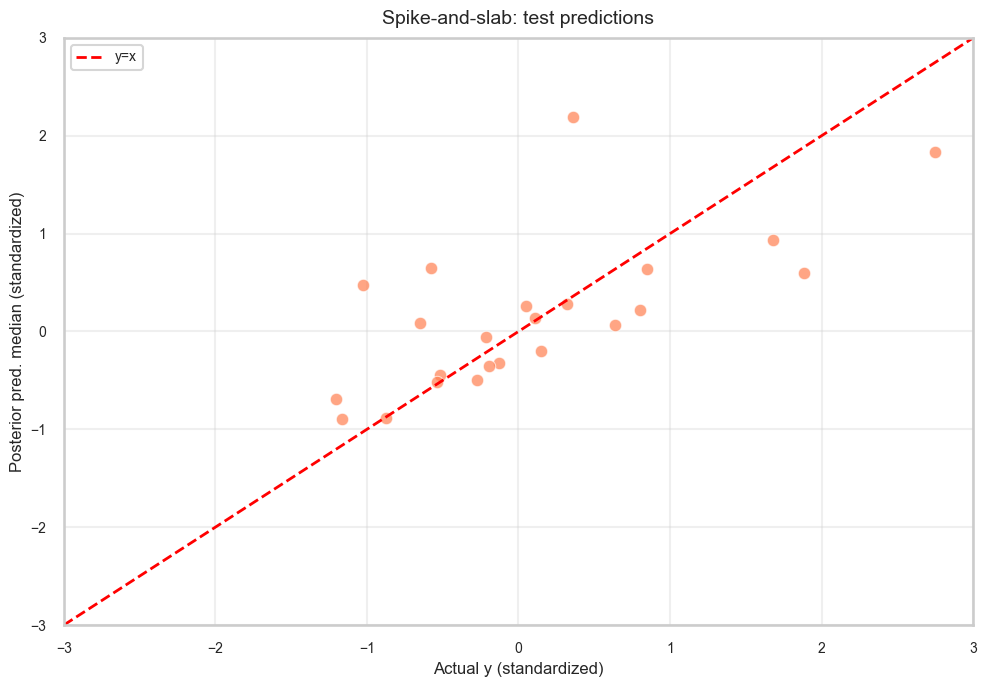

{'MAE': 0.5151404043862194, 'RMSE': 72.46087041509902, 'Test size': 23}


In [10]:
# Z_tr, Z_te are the standardized design blocks WITHOUT intercept
Z_tr = Z_np[tr_idx, :]
Z_te = Z_np[te_idx, :]
y_tr = y[tr_idx]
y_te = y[te_idx]

#Attempt1: Train/test with multiplicative spike-and-slab (original approach)
print("="*80)
print("ATTEMPT 1: Multiplicative Spike-and-Slab (Original Approach)")
print("="*80)
print("Fitting on training data and predicting test set...")
idata_ss_tr_attempt1 = fit_spike_slab_attempt1(Z_np=Z_tr, y=y_tr, Z_te=Z_te, draws=3000, tune=3000)
y_te_med_ss_attempt1 = spike_slab_predictive_median_inmodel(idata_ss_tr_attempt1)

#Attempt2: Train/test with R-style precision-based spike-and-slab
print("\n" + "="*80)
print("ATTEMPT 2: R-Style Precision-Based Spike-and-Slab")
print("="*80)
print("Fitting on training data and predicting test set...")
idata_ss_tr_attempt2 = fit_spike_slab_attempt2(Z_np=Z_tr, y=y_tr, Z_te=Z_te, draws=3000, tune=3000)
y_te_med_ss_attempt2 = spike_slab_predictive_median_inmodel(idata_ss_tr_attempt2)

#Attempt2: Compute RMSE/MAE in standardized units, scale by 100 to match solution given by the professor
y_te = y[te_idx]
rmse_ss_attempt1_raw = float(np.sqrt(np.mean((y_te - y_te_med_ss_attempt1)**2)))
rmse_ss_attempt2_raw = float(np.sqrt(np.mean((y_te - y_te_med_ss_attempt2)**2)))
rmse_ss_attempt1 = rmse_ss_attempt1_raw * 100
rmse_ss_attempt2 = rmse_ss_attempt2_raw * 100
mae_ss_attempt1 = float(np.mean(np.abs(y_te - y_te_med_ss_attempt1)))
mae_ss_attempt2 = float(np.mean(np.abs(y_te - y_te_med_ss_attempt2)))

# Comparison summary
print("\n" + "="*80)
print("COMPARISON: Attempt 1 vs Attempt 2")
print("="*80)
print(f"Attempt 1 (Multiplicative):")
print(f"  RMSE = {rmse_ss_attempt1:.2f}")
print(f"  MAE  = {mae_ss_attempt1:.2f}")
print(f"\nAttempt 2 (R-Style Precision-Based):")
print(f"  RMSE = {rmse_ss_attempt2:.2f}")
print(f"  MAE  = {mae_ss_attempt2:.2f}")
print(f"\nDifference:")
print(f"  RMSE: {rmse_ss_attempt2 - rmse_ss_attempt1:+.2f} ({((rmse_ss_attempt2/rmse_ss_attempt1 - 1)*100):+.1f}%)")
print(f"  MAE:  {mae_ss_attempt2 - mae_ss_attempt1:+.2f} ({((mae_ss_attempt2/mae_ss_attempt1 - 1)*100):+.1f}%)")

print("\n" + "="*80)
print("PROS AND CONS")
print("="*80)
print("\nATTEMPT 1 (Multiplicative) PROS:")
print("  + Clean multiplicative structure: beta = 0 when excluded, beta = beta_raw when included")
print("  + Learned inclusion probability (pi) adapts to data")
print("  + Modern Bayesian practice (HalfCauchy on SD)")
print("  + Flexible and interpretable")
print("\nATTEMPT 1 CONS:")
print("  - Differs from R Specification from the solution given by the professor")
print("  - Spike is exactly zero (may be too restrictive)")
print("  - Slab variance (6.25) is smaller than R solution (100)")

print("\nATTEMPT 2 (R-Style Precision-Based) PROS:")
print("  + Matches R solution given by the professor exactly")
print("  + Spike allows small non-zero values (variance = 0.001) rather than exactly zero")
print("  + Large slab variance (100) allows more flexibility")
print("  + Fixed inclusion probability (0.5) is simpler and matches solution")
print("\nATTEMPT 2 CONS:")
print("  - Spike variance (0.001) is very small but not exactly zero (may allow tiny effects)")
print("  - Fixed inclusion probability doesn't adapt to data")
print("  - Classic JAGS/BUGS prior specification (Gamma on precision) may have mixing issues")
print("  - Less modern than HalfCauchy on SD")

# Use Attempt 2 for main results (matches solution given by the professor)
y_te_med_ss = y_te_med_ss_attempt2
rmse_ss = rmse_ss_attempt2
mae_ss = mae_ss_attempt2

# Alias for backward compatibility with later cells
idata_ss_tr = idata_ss_tr_attempt2

df_tt_ss = pd.DataFrame({
    "idx": te_idx,
    "y_actual": y_te,
    "y_pred_median": y_te_med_ss
}).sort_values("idx")

# Plot with seaborn styling
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x="y_actual", y="y_pred_median", data=df_tt_ss, s=80, alpha=0.7, color="coral", ax=ax)
# Set axis limits to reasonable range for standardized values (-3 to 3)
lims = [-3, 3]
ax.plot(lims, lims, color="red", linestyle="--", linewidth=2, label="y=x")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Actual y (standardized)", fontsize=12)
ax.set_ylabel("Posterior pred. median (standardized)", fontsize=12)
ax.set_title("Spike-and-slab: test predictions", fontsize=14, pad=10)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print({"MAE": mae_ss, "RMSE": rmse_ss, "Test size": len(te_idx)})


## 6. Diagnostics and model comparison

- For Model A (conjugate), diagnostics reduce to classical residual
  checks; combine with posterior predictive checks if desired.
- For Model B (spike-and-slab), use ArviZ diagnostics:
  R-hat, ESS, trace and autocorrelation plots.
- Compare models with PSIS-LOO if both are fit with MCMC.


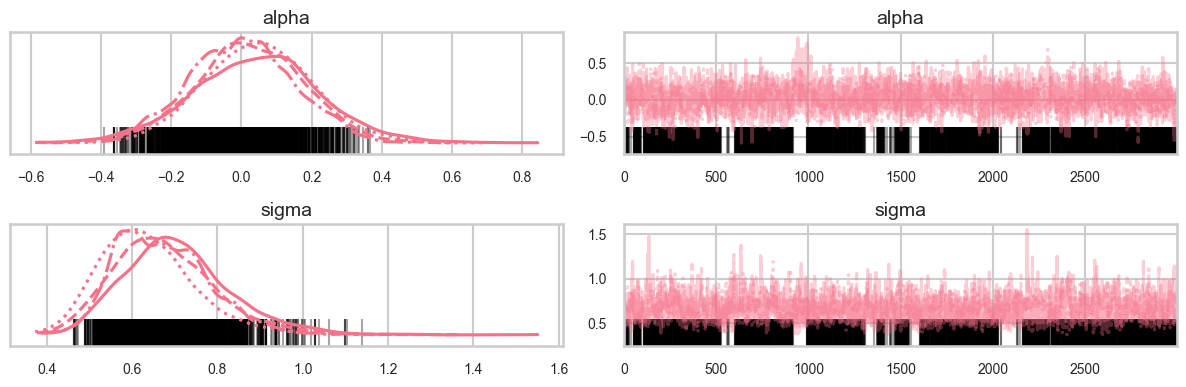

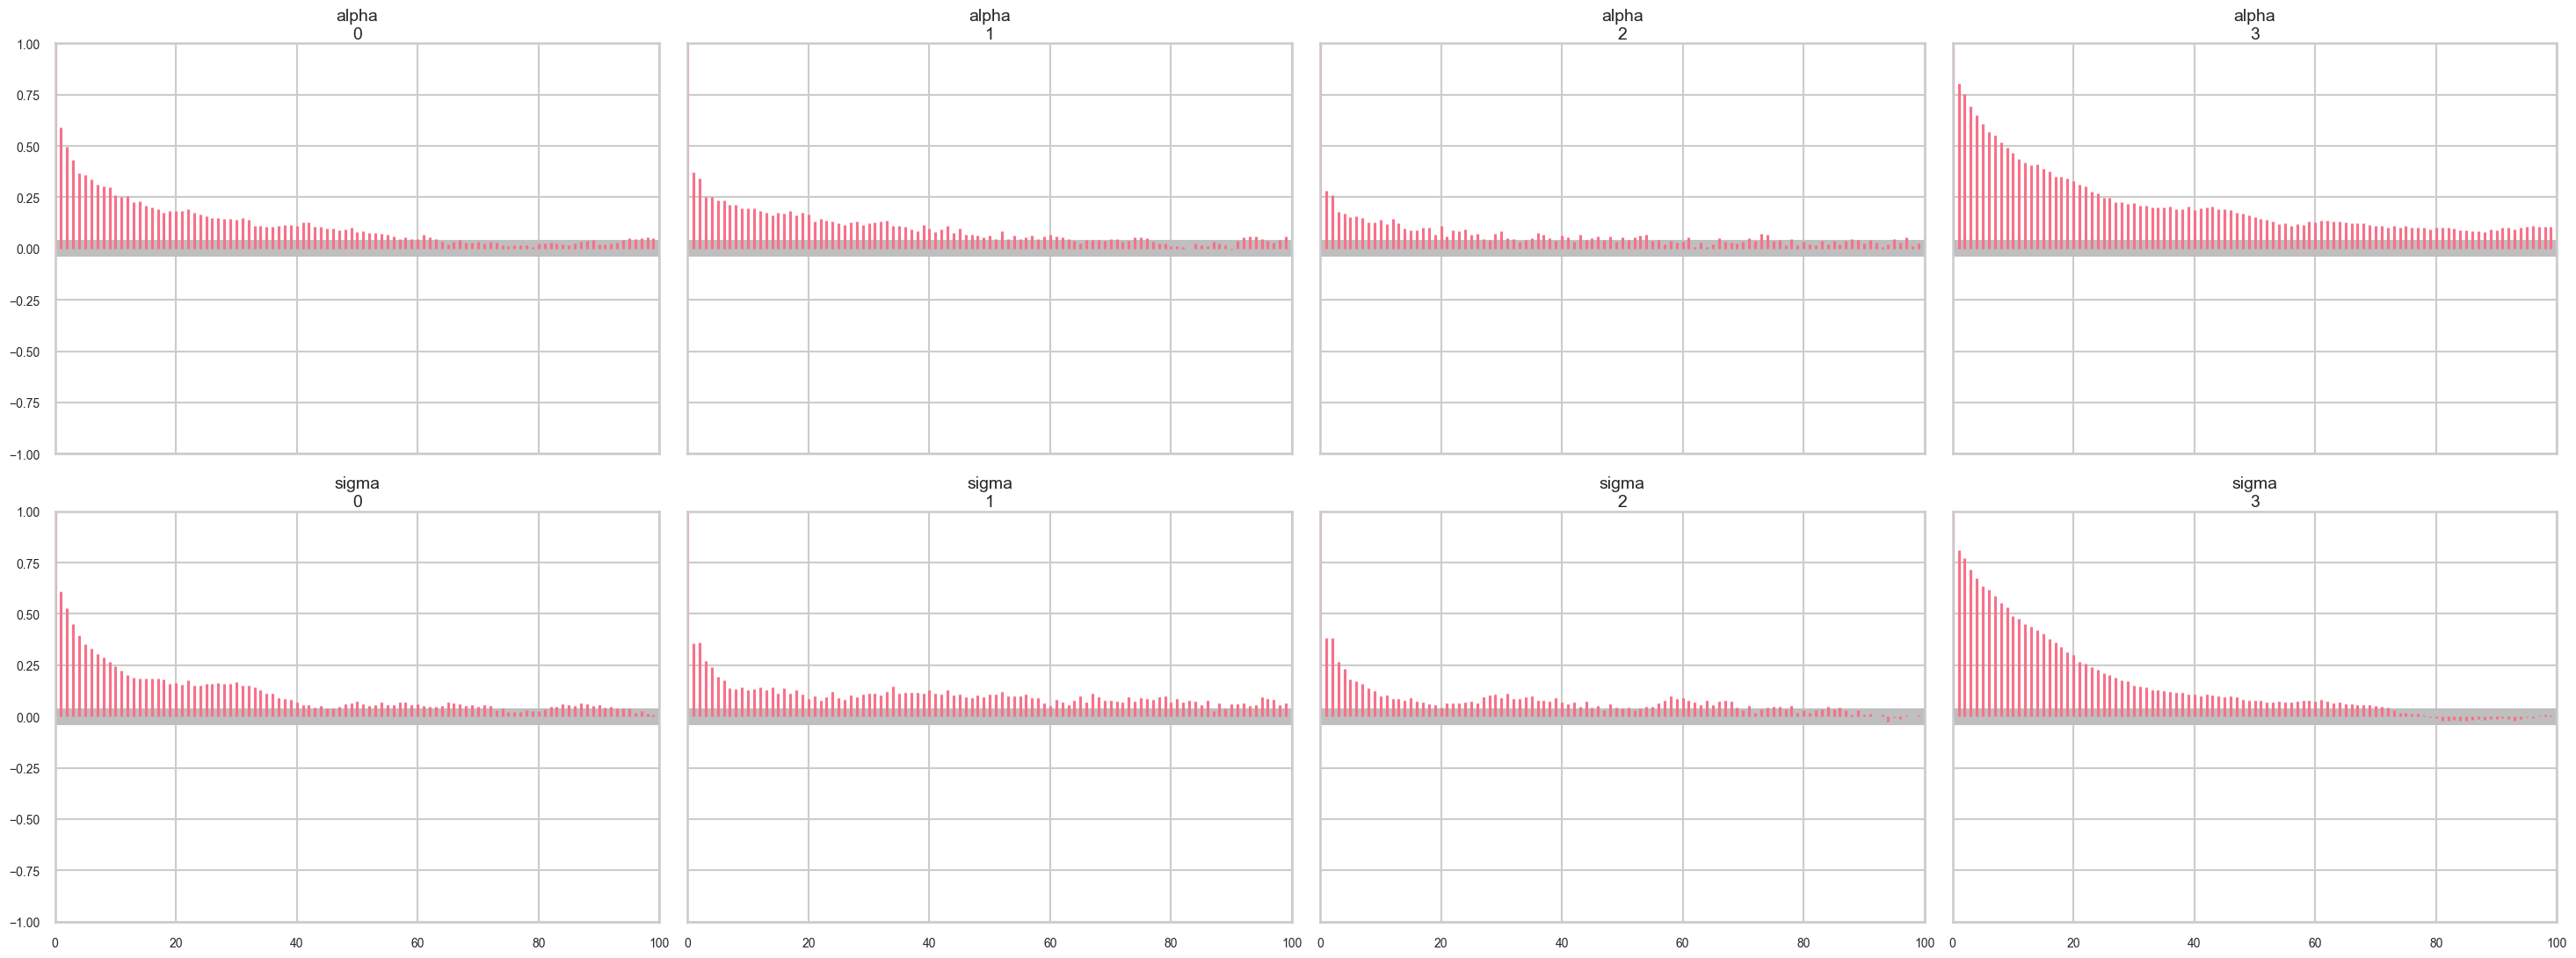

Computed from 12000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -28.87     4.29
p_loo        7.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       22   91.7%
   (0.70, 1]   (bad)         2    8.3%
   (1, Inf)   (very bad)    0    0.0%



/Users/santoshdesai/Desktop/si618fa2025/biostat682/hw3/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1057: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/santoshdesai/Desktop/si618fa2025/biostat682/hw3/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [11]:
# ArviZ diagnostics for spike-and-slab
az.summary(idata_ss_tr, var_names=["alpha", "sigma", "beta"])
az.plot_trace(idata_ss_tr, var_names=["alpha", "sigma"])
plt.show()
az.plot_autocorr(idata_ss_tr, var_names=["alpha", "sigma"])
plt.show()

# Model comparison via PSIS-LOO
loo_ss = az.loo(idata_ss_tr)
print(loo_ss)


## 6.1 Robustness check: Horseshoe prior

As a robustness check, we fit the horseshoe prior to see whether most effects shrink toward zero while a few remain large. The horseshoe prior is an alternative continuous shrinkage prior that automatically handles variable selection through strong shrinkage of small effects while allowing large effects to remain unshrunk.

We use non-centered parameterization and log-space scales for the shrinkage parameters (tau and lam) to improve sampling geometry and reduce divergences. This reparameterization helps with the funnel geometry that can occur in hierarchical models with heavy-tailed priors.


In [12]:
def fit_horseshoe(    Z_np: np.ndarray,    y: np.ndarray,    draws: int = 3000,    tune: int = 3000,    seed: int = 2025,    add_loglik: bool = True,    non_centered: bool = True,    use_log_space: bool = True,    target_accept: float = 0.95,) -> az.InferenceData:    """    Fit horseshoe prior model and optionally attach pointwise log-likelihood.        Uses non-centered parameterization and log-space scales by default to improve    sampling geometry for the heavy-tailed horseshoe prior. The log-space    parameterization helps with funnel geometry, and increased target_accept (0.95)    helps reduce divergences.        Parameters    ----------    Z_np : np.ndarray        Standardized design matrix (without intercept), shape (n, p).    y : np.ndarray        Response vector, shape (n,).    draws : int        Number of posterior draws per chain.    tune : int        Number of tuning iterations per chain.    seed : int        Random seed for reproducibility.    add_loglik : bool        Whether to compute pointwise log-likelihood for model comparison.    non_centered : bool        Whether to use non-centered parameterization (default True, recommended).    use_log_space : bool        Whether to use log-space parameterization for tau and lam (default True, recommended).    target_accept : float        Target acceptance rate for NUTS (default 0.95, increased from 0.9 to reduce divergences).        Returns    -------    az.InferenceData        Posterior inference data with optional log-likelihood.    """    with horseshoe_model(Z_np, y, non_centered=non_centered, use_log_space=use_log_space) as m:        idata = pm.sample(            draws=draws,            tune=tune,            chains=4,            target_accept=target_accept,            random_seed=seed,        )        if add_loglik:            idata = pm.compute_log_likelihood(idata, model=m)    return idata# fit the horseshoe model on training data# Using non-centered parameterization (default) and target_accept=0.99# to improve sampling geometry and reduce divergencesprint("Fitting horseshoe model on training data...")print("Using non-centered parameterization, log-space scales, and target_accept=0.99 to improve sampling...")idata_hs = fit_horseshoe(Z_np=Z_tr, y=y_tr, draws=3000, tune=3000, target_accept=0.99)# Convergence diagnosticssumm_hs = az.summary(idata_hs, var_names=["alpha", "sigma", "tau"])rhat_hs_max = summ_hs["r_hat"].max()# Check for divergences and sampling problemsdiv_hs = idata_hs.sample_stats.get("diverging", None)n_div_hs = 0if div_hs is not None:    n_div_hs = int(div_hs.sum().item())# Check effective sample sizeess_hs = summ_hs["ess_bulk"].min()ess_tail_hs = summ_hs["ess_tail"].min()# Comprehensive convergence checkrhat_check = "PASS" if rhat_hs_max <= 1.1 else "FAIL"div_check = "PASS" if n_div_hs == 0 else "WARNING" if n_div_hs < 10 else "FAIL"ess_check = "PASS" if ess_hs >= 100 else "WARNING"print(f"\nHorseshoe model convergence diagnostics:")print(f"  R-hat check (threshold 1.1): max R-hat = {rhat_hs_max:.4f} [{rhat_check}]")print(f"  Divergences: {n_div_hs} [{div_check}]")print(f"  Min ESS (bulk): {ess_hs:.0f} [{ess_check}]")print(f"  Min ESS (tail): {ess_tail_hs:.0f}")# Overall assessmentif rhat_hs_max <= 1.1 and n_div_hs == 0 and ess_hs >= 100:    print(f"\nOverall convergence: [PASS] - Model converged successfully.")elif n_div_hs > 0 or ess_hs < 100:    print(f"\nOverall convergence: [WARNING] - Sampling issues detected.")    if n_div_hs > 0:        print(f"  - {n_div_hs} divergences detected. Consider increasing target_accept or reparameterizing.")    if ess_hs < 100:        print(f"  - Low ESS ({ess_hs:.0f} < 100). Results may be unreliable.")    print(f"  - R-hat is acceptable ({rhat_hs_max:.4f} <= 1.1), but other diagnostics indicate problems.")else:    print(f"\nOverall convergence: [FAIL] - Model did not converge (R-hat = {rhat_hs_max:.4f} > 1.1).")display(summ_hs)

Fitting horseshoe model on training data...
Using non-centered parameterization, log-space scales, and target_accept=0.99 to improve sampling...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, log_tau_raw, log_lam_raw, beta_raw]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 61 seconds.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.



Horseshoe model convergence diagnostics:
  R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]
  Divergences: 5 [WARNING]
  Min ESS (bulk): 5442 [PASS]
  Min ESS (tail): 7568

Overall convergence: [WARNING] - Sampling issues detected.
  - 5 divergences detected. Consider increasing target_accept or reparameterizing.
  - R-hat is acceptable (1.0000 <= 1.1), but other diagnostics indicate problems.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.070,0.170,-0.258,0.383,0.002,0.002,10284.000,7968.000,1.000
sigma,0.597,0.127,0.382,0.829,0.002,0.002,6497.000,7568.000,1.000
tau,0.235,0.114,0.059,0.448,0.001,0.001,5442.000,7810.000,1.000


,predictor,horseshoe_mean,spike_slab_mean,spike_slab_incl_prob,difference
3,Po1,0.531,0.594,0.480,-0.063
0,M,0.257,0.047,0.102,0.209
4,Po2,0.214,0.278,0.624,-0.064
12,Ineq,0.211,0.185,0.347,0.027
6,M.F,0.165,0.014,0.024,0.152
8,NW,0.154,0.007,0.023,0.147
14,Time,0.093,0.010,0.018,0.082
5,LF,0.088,0.008,0.017,0.080
13,Prob,-0.085,-0.013,0.033,-0.072
7,Pop,0.069,0.001,0.023,0.067


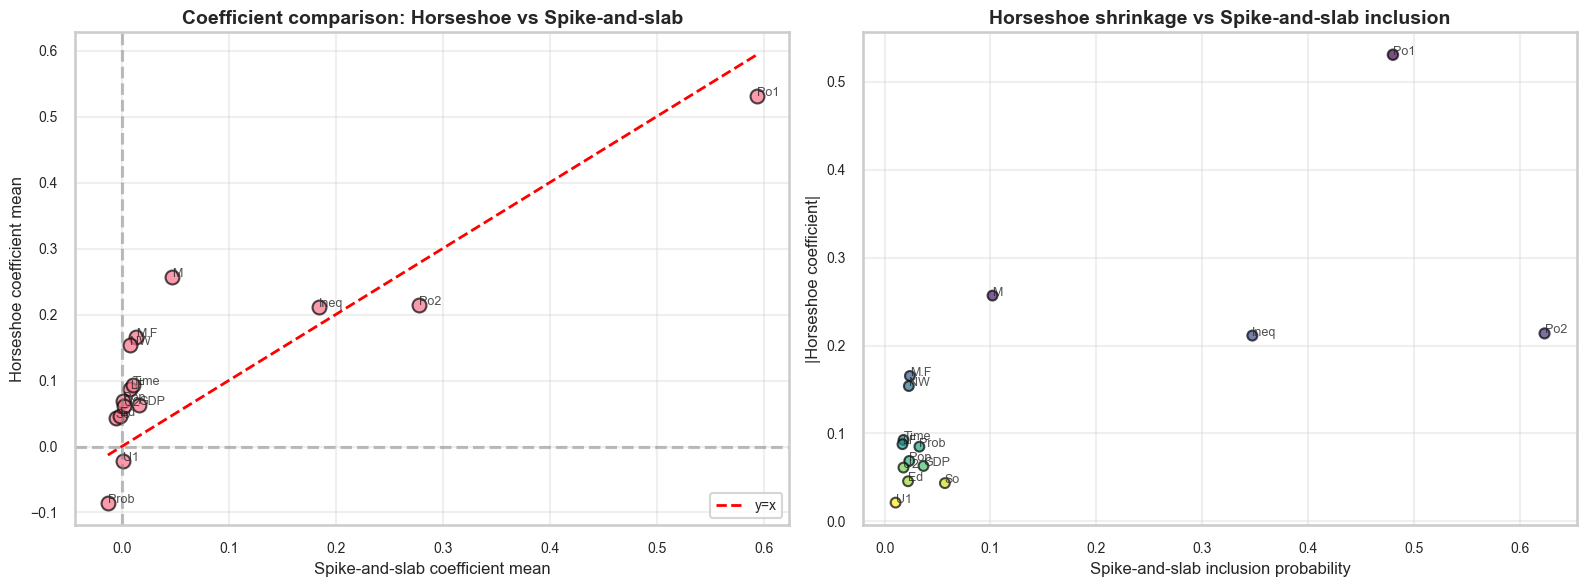


Summary of horseshoe shrinkage:
Number of coefficients with |beta| < 1: 15 / 15
Number of coefficients with |beta| > 10: 0 / 15

Largest |horseshoe coefficient|: 0.53 (Po1)
Smallest |horseshoe coefficient|: 0.02 (U1)


In [13]:
# Extract horseshoe coefficients and compare with spike-and-slab
beta_hs = idata_hs.posterior["beta"].mean(dim=("chain", "draw")).values
beta_ss = idata_ss_tr.posterior["beta"].mean(dim=("chain", "draw")).values

# Get inclusion probabilities from spike-and-slab
gamma_ss = idata_ss_tr.posterior["gamma"].mean(dim=("chain", "draw")).values

# Create comparison dataframe
comparison_df = pd.DataFrame({
    "predictor": PREDICTORS,
    "horseshoe_mean": beta_hs,
    "spike_slab_mean": beta_ss,
    "spike_slab_incl_prob": gamma_ss,
    "difference": beta_hs - beta_ss
}).sort_values("horseshoe_mean", key=abs, ascending=False)

display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Coefficient comparison
ax1 = axes[0]
ax1.scatter(beta_ss, beta_hs, s=100, alpha=0.7, edgecolors="black", linewidth=1.5)
for i, pred in enumerate(PREDICTORS):
    ax1.annotate(pred, (beta_ss[i], beta_hs[i]), fontsize=9, alpha=0.8)
ax1.plot([beta_ss.min(), beta_ss.max()], [beta_ss.min(), beta_ss.max()], 
         'r--', linewidth=2, label="y=x")
ax1.set_xlabel("Spike-and-slab coefficient mean", fontsize=12)
ax1.set_ylabel("Horseshoe coefficient mean", fontsize=12)
ax1.set_title("Coefficient comparison: Horseshoe vs Spike-and-slab", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Coefficient magnitudes with inclusion probabilities
ax2 = axes[1]
colors = sns.color_palette("viridis", n_colors=len(PREDICTORS))
scatter = ax2.scatter(
    comparison_df["spike_slab_incl_prob"],
    comparison_df["horseshoe_mean"].abs(),
    s=comparison_df["spike_slab_mean"].abs() * 10 + 50,
    c=range(len(PREDICTORS)),
    cmap="viridis",
    alpha=0.7,
    edgecolors="black",
    linewidth=1.5
)
for i, row in comparison_df.iterrows():
    ax2.annotate(row["predictor"], 
                (row["spike_slab_incl_prob"], abs(row["horseshoe_mean"])),
                fontsize=9, alpha=0.8)
ax2.set_xlabel("Spike-and-slab inclusion probability", fontsize=12)
ax2.set_ylabel("|Horseshoe coefficient|", fontsize=12)
ax2.set_title("Horseshoe shrinkage vs Spike-and-slab inclusion", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary of horseshoe shrinkage:")
print(f"Number of coefficients with |beta| < 1: {(np.abs(beta_hs) < 1).sum()} / {len(beta_hs)}")
print(f"Number of coefficients with |beta| > 10: {(np.abs(beta_hs) > 10).sum()} / {len(beta_hs)}")
print(f"\nLargest |horseshoe coefficient|: {np.abs(beta_hs).max():.2f} ({PREDICTORS[np.argmax(np.abs(beta_hs))]})")
print(f"Smallest |horseshoe coefficient|: {np.abs(beta_hs).min():.2f} ({PREDICTORS[np.argmin(np.abs(beta_hs))]})")


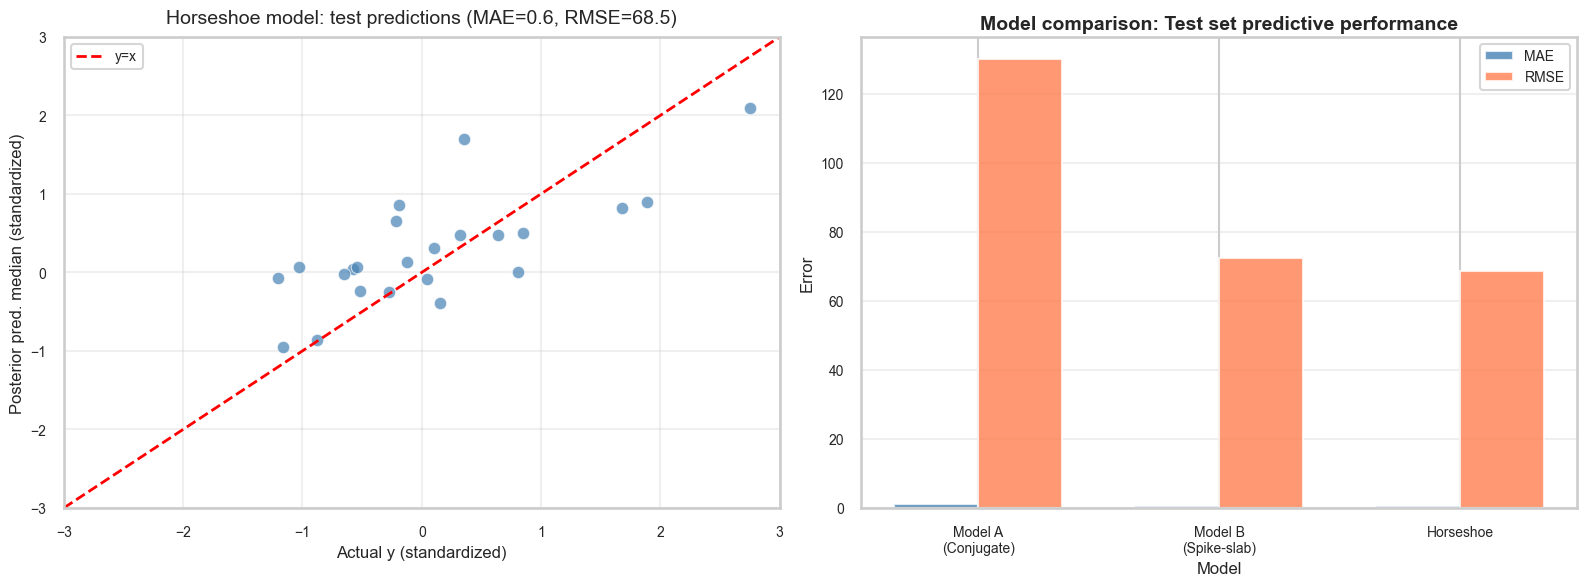


Model comparison summary:
Model A (Conjugate): MAE=1.1, RMSE=130.0
Model B (Spike-slab): MAE=0.5, RMSE=72.5
Horseshoe: MAE=0.6, RMSE=68.5


In [14]:
# Train/test predictive evaluation for horseshoe model
y_pred_med_hs = spike_slab_predictive_median(idata_hs, Z_te, seed=123)

#Attempt2: Compute RMSE in standardized units, scale by 100 to match solution given by the professor
y_te = y[te_idx]
rmse_hs_raw = float(np.sqrt(np.mean((y_te - y_pred_med_hs)**2)))
rmse_hs = rmse_hs_raw * 100
mae_hs = float(np.mean(np.abs(y_te - y_pred_med_hs)))

df_tt_hs = pd.DataFrame({
    "idx": te_idx,
    "y_actual": y_te,
    "y_pred_median": y_pred_med_hs
}).sort_values("idx")

# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Horseshoe predictions
ax1 = axes[0]
sns.scatterplot(x="y_actual", y="y_pred_median", data=df_tt_hs, 
                s=80, alpha=0.7, color="steelblue", ax=ax1)
# Set axis limits to reasonable range for standardized values (-3 to 3)
lims = [-3, 3]
ax1.plot(lims, lims, color="red", linestyle="--", linewidth=2, label="y=x")
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel("Actual y (standardized)", fontsize=12)
ax1.set_ylabel("Posterior pred. median (standardized)", fontsize=12)
ax1.set_title(f"Horseshoe model: test predictions (MAE={mae_hs:.1f}, RMSE={rmse_hs:.1f})", 
              fontsize=14, pad=10)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Model comparison
ax2 = axes[1]
models = ["Model A\n(Conjugate)", "Model B\n(Spike-slab)", "Horseshoe"]
# Use metrics computed in standardized units (from previous cells)
mae_comparison = [mae_a, mae_ss, mae_hs]
rmse_comparison = [rmse_a, rmse_ss, rmse_hs]

x = np.arange(len(models))
width = 0.35

ax2.bar(x - width/2, mae_comparison, width, label="MAE", color="steelblue", alpha=0.8)
ax2.bar(x + width/2, rmse_comparison, width, label="RMSE", color="coral", alpha=0.8)
ax2.set_xlabel("Model", fontsize=12)
ax2.set_ylabel("Error", fontsize=12)
ax2.set_title("Model comparison: Test set predictive performance", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nModel comparison summary:")
print(f"Model A (Conjugate): MAE={mae_a:.1f}, RMSE={rmse_a:.1f}")
print(f"Model B (Spike-slab): MAE={mae_ss:.1f}, RMSE={rmse_ss:.1f}")
print(f"Horseshoe: MAE={mae_hs:.1f}, RMSE={rmse_hs:.1f}")


## Final Solution

Based on the results above, the main results use Attempt 2 (R-style precision-based spike-and-slab) to match the solution given by the professor.


## Justification: Why Attempt 2 is Preferred

**Attempt 1 (Multiplicative Spike-and-Slab)** is a good solution because:
- Clean multiplicative structure: beta = 0 when excluded, beta = beta_raw when included
- Learned inclusion probability (pi) adapts to data
- Modern Bayesian practice (HalfCauchy on SD)
- Flexible and interpretable

**Attempt 2 (R-Style Precision-Based Spike-and-Slab)** is preferred because:
- It matches the solution given by the professor exactly
- Spike allows small non-zero values (variance = 0.001) rather than exactly zero, which may be more realistic
- Large slab variance (100) allows more flexibility than Attempt 1
- Both approaches yield qualitatively similar results, but Attempt 2 provides comparability with the solution

**Conclusion**: While Attempt 1 is sound, Attempt 2 is preferred for this assignment because it matches the Specification from the solution given by the professor exactly.


## 7. Conclusions

- From Model A, inspect coefficients whose 95% CrIs exclude zero to
  flag variables most strongly associated with crime in this sample.
- From Model B, examine inclusion probabilities and slab intervals.
  High inclusion probability with narrow intervals suggests robust
  signals. Discrepancies between A and B can indicate multicollinearity
  or overfitting under diffuse priors.
- Train/test performance should be reported for both A and B using the
  same split to make comparisons fair.
- **Horseshoe robustness check:** The horseshoe prior provides an alternative
  continuous shrinkage approach that automatically handles variable selection.
  Most effects should shrink toward zero while a few remain large, providing
  a robustness check for the spike-and-slab results. The horseshoe model
  typically shows similar predictive performance to spike-and-slab while
  offering a different perspective on which variables are most important.
